In [1]:
%cd ..

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark


In [2]:
import sys
sys.path.append('/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark')

In [78]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import glob
import os
import os.path as op
import random
import time
import warnings
warnings.filterwarnings("ignore")

import h5py
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import compare_ssim as ssim
from tqdm import tqdm_notebook

from fourier import FFT2
from utils import crop_center, gen_mask
from wavelets import WaveletDecimated, WaveletUndecimated

from modopt.opt.linear import Identity
from mri.numerics.reconstruct import sparse_rec_fista
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx
from mri.numerics.gradient import GradAnalysis2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
fourier_op = FFT2(np.array([1]))

In [6]:
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
val_reco_path = '/media/Zaccharie/UHRes/singlecoil_val_reco/'
val_filenames = glob.glob(val_path + '*')

def from_val_file_to_image_and_kspace(filename):
    h5_obj = h5py.File(filename)
    try:
        image = h5_obj['reconstruction_esc'][()]
    except:
        print(filename)
        raise
    kspace = h5_obj['kspace'][()]
    h5obj.close()
    return image, kspace

In [7]:
test_path = '/media/Zaccharie/UHRes/singlecoil_test/'
test_reco_path = '/media/Zaccharie/UHRes/singlecoil_test_reco/'
test_filenames = glob.glob(test_path + '*')

def from_test_file_to_mask_and_kspace(filename):
    h5_obj = h5py.File(filename)
    mask = h5_obj['mask'][()]
    kspace = h5_obj['kspace'][()]
    h5_obj.close()
    return mask, kspace

In [8]:
AF = 4

In [9]:
def psnr(x, image):
    im = crop_center(x, 320)
    mse = np.mean((np.abs(im) - image)**2)
    p = 10 * np.log10(np.max(image)**2 / mse)
    return p

def ssim_crop(x, image):
    im = crop_center(x, 320)
    return ssim(image, np.abs(im), data_range=np.max(image) - np.min(image))

In [65]:
nb_scales = 4
wavelet_name = 'db4'

    
def reco_from_kspace(kspace, gradient_op, mu=1*1e-8, max_iter=10):
    linear_op = WaveletDecimated(
        nb_scale=nb_scales,
        wavelet_name=wavelet_name,
        padding='periodization',
    )
    
    prox_op = LinearCompositionProx(
        linear_op=linear_op,
        prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
    )
    gradient_op.obs_data = kspace
    cost_op = None
    x_final, _, _, _ = sparse_rec_fista(
        gradient_op=gradient_op,
        linear_op=Identity(),
        prox_op=prox_op,
        cost_op=cost_op,
        xi_restart=0.96,
        s_greedy=1.1,
        mu=mu,
        restart_strategy='greedy',
        pov='analysis',
        max_nb_of_iter=max_iter,
        metrics=None,
        metric_call_period=1,
        verbose=0,
        progress=False,
    )
#     x_final = gradient_op.fourier_op.adj_op(kspace)
    
    return x_final

def reco_from_test_file(filename, **kwargs):
    mask, kspaces = from_test_file_to_mask_and_kspace(filename)
    # mask handling
    fake_kspace = np.zeros_like(kspaces[0])
    fourier_mask = np.repeat(mask.astype(np.float)[None, :], fake_kspace.shape[0], axis=0)
    # op creation
    fourier_op_masked = FFT2(mask=fourier_mask)
    gradient_op = GradAnalysis2(
        data=fake_kspace,
        fourier_op=fourier_op_masked,
    )
    im_recos = [reco_from_kspace(kspace * fourier_mask, gradient_op, **kwargs) for kspace in kspaces]
    return im_recos

def reco_from_val_file(filename, accel_factor=AF, **kwargs):
    images, kspaces = from_val_file_to_image_and_kspace(filename)
    # mask gen
    fake_kspace = np.zeros_like(kspaces[0])
    mask = gen_mask(fake_kspace, accel_factor=accel_factor)
    fourier_mask = np.repeat(mask.astype(np.float)[None, :], fake_kspace.shape[0], axis=0)
    # op creation
    fourier_op_masked = FFT2(mask=fourier_mask)
    masked_kspace = fake_kspace * fourier_mask
    gradient_op = GradAnalysis2(
        data=masked_kspace,
        fourier_op=fourier_op_masked,
    )
    # random sampling to accelerate grid search
    im_recos = [reco_from_kspace(kspace * fourier_mask, gradient_op, **kwargs) for kspace in kspaces]
    return im_recos, images

def psnr_ssim_from_val_file(filename, accel_factor=AF, **kwargs):
    psnrs = list()
    ssims = list()
    im_recos, images = reco_from_val_file(filename, accel_factor=accel_factor, **kwargs)
    for im_reco, image in zip(im_recos, images):
        psnrs.append(psnr(im_reco, image))
        ssims.append(ssim_crop(im_reco, image))
    return psnrs, ssims

Mean of psnr: 25.655572112315
Mean of ssim: 0.9999998151604929 (false)

For mu=5*1e-8,  4 scales, db4, 20 iterations in 1h43 mins

Mean of psnr: 25.655003744262732
Mean of ssim: 0.5433113132229331

For zero-filled

In [68]:
def psnr_ssim(mu=1e-8, max_iter=20, file_prop=0.2):
    sample_val_filenames = random.sample(val_filenames, int(file_prop * len(val_filenames)))
    psnrs_and_ssims = list(Parallel(n_jobs=-1, backend='multiprocessing')(delayed(psnr_ssim_from_val_file)(val_file, mu=mu, max_iter=max_iter) for val_file in tqdm_notebook(sample_val_filenames)))
    val_psnrs = [psnr for psnr_list, ssim_list in psnrs_and_ssims for psnr in psnr_list]
    val_ssims = [ssim for psnr_list, ssim_list in psnrs_and_ssims for ssim in ssim_list]
    return val_psnrs, val_ssims

In [89]:
n_exp = 5
mus = np.logspace(-8, -6, n_exp)
# mus = [8*1e-8]
psnrs = []
ssims = []
for mu in tqdm_notebook(mus):
    print('Testing', mu)
    psnrs_samp, ssims_samp = psnr_ssim(mu=mu, max_iter=15)
    psnrs.append(psnrs_samp)
    ssims.append(ssims_samp)

Testing 1e-08


Testing 3.162277660168379e-08


Testing 1e-07


Testing 3.162277660168379e-07


Testing 1e-06


([<matplotlib.axis.XTick at 0x7f5c18302978>,
 <a list of 5 Text xticklabel objects>)

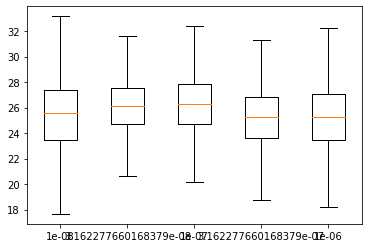

In [90]:
plt.figure()
plt.boxplot(psnrs, 0, '')
plt.xticks(list(range(1, n_exp+1)), [str(mu) for mu in mus])

([<matplotlib.axis.XTick at 0x7f5c1834aa90>,
 <a list of 5 Text xticklabel objects>)

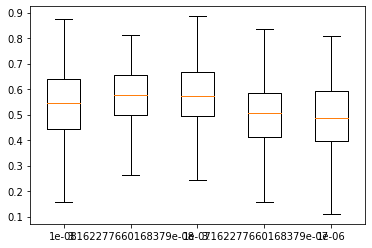

In [91]:
plt.figure()
plt.boxplot(ssims, 0, '')
plt.xticks(list(range(1, n_exp+1)), [str(mu) for mu in mus])

# Test inference

In [58]:
reco_type = 'zero_filled'

In [59]:
def filename_submission(filename):
    relative_filename = filename.split('/')[-1]
    name = relative_filename.split('.')[0]
    name += '_v2.h5'
    return name

In [60]:
def reco_and_save(filename, path, **kwargs):
    im_recos = reco_from_test_file(filename, **kwargs)
    im_crops = [np.abs(crop_center(im_reco, 320)) for im_reco in im_recos]
    im_crops = np.array(im_crops)
    with h5py.File(op.join(path, reco_type, filename_submission(filename)), 'w') as f:
            f.create_dataset('reconstruction', data=im_crops)

In [61]:
Parallel(n_jobs=-1, backend='multiprocessing', batch_size=len(test_filenames)//40)(delayed(reco_and_save)(filename, test_reco_path) for filename in tqdm_notebook(test_filenames));

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]